# <center> MATH&ML-13. Временные ряды. Часть II. Практика

In [166]:
# Импорты
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.api import SimpleExpSmoothing
from statsmodels.tsa.stattools import adfuller
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm
from sklearn.model_selection import TimeSeriesSplit
from arch import arch_model
from sklearn.linear_model import LinearRegression

from warnings import filterwarnings

filterwarnings("ignore")

In [ ]:
#Читаем дата-сет
ghana_data = pd.read_csv('data/ghana_gdp.zip', parse_dates=["year"], index_col=["year"])
ghana_data = pd.DataFrame(ghana_data['GDP (current US$)'].rename('GDP_col'))
ghana_data

,GDP_col
year,
1960-01-01,1.217087e+09
1961-01-01,0.000000e+00
1962-01-01,1.382353e+09
1963-01-01,1.540616e+09
1964-01-01,1.731092e+09
...,...
2017-01-01,6.040638e+10
2018-01-01,6.729928e+10
2019-01-01,6.833754e+10


In [ ]:
#Общая информация о дата-сете
ghana_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 62 entries, 1960-01-01 to 2021-01-01
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   GDP_col  62 non-null     float64
dtypes: float64(1)
memory usage: 992.0 bytes


Замечу, что ВВП в 1961 году 0. Скорее всего это выброс. Информации по этому поводу в интернете нет.

## Статистические модели прогнозирования

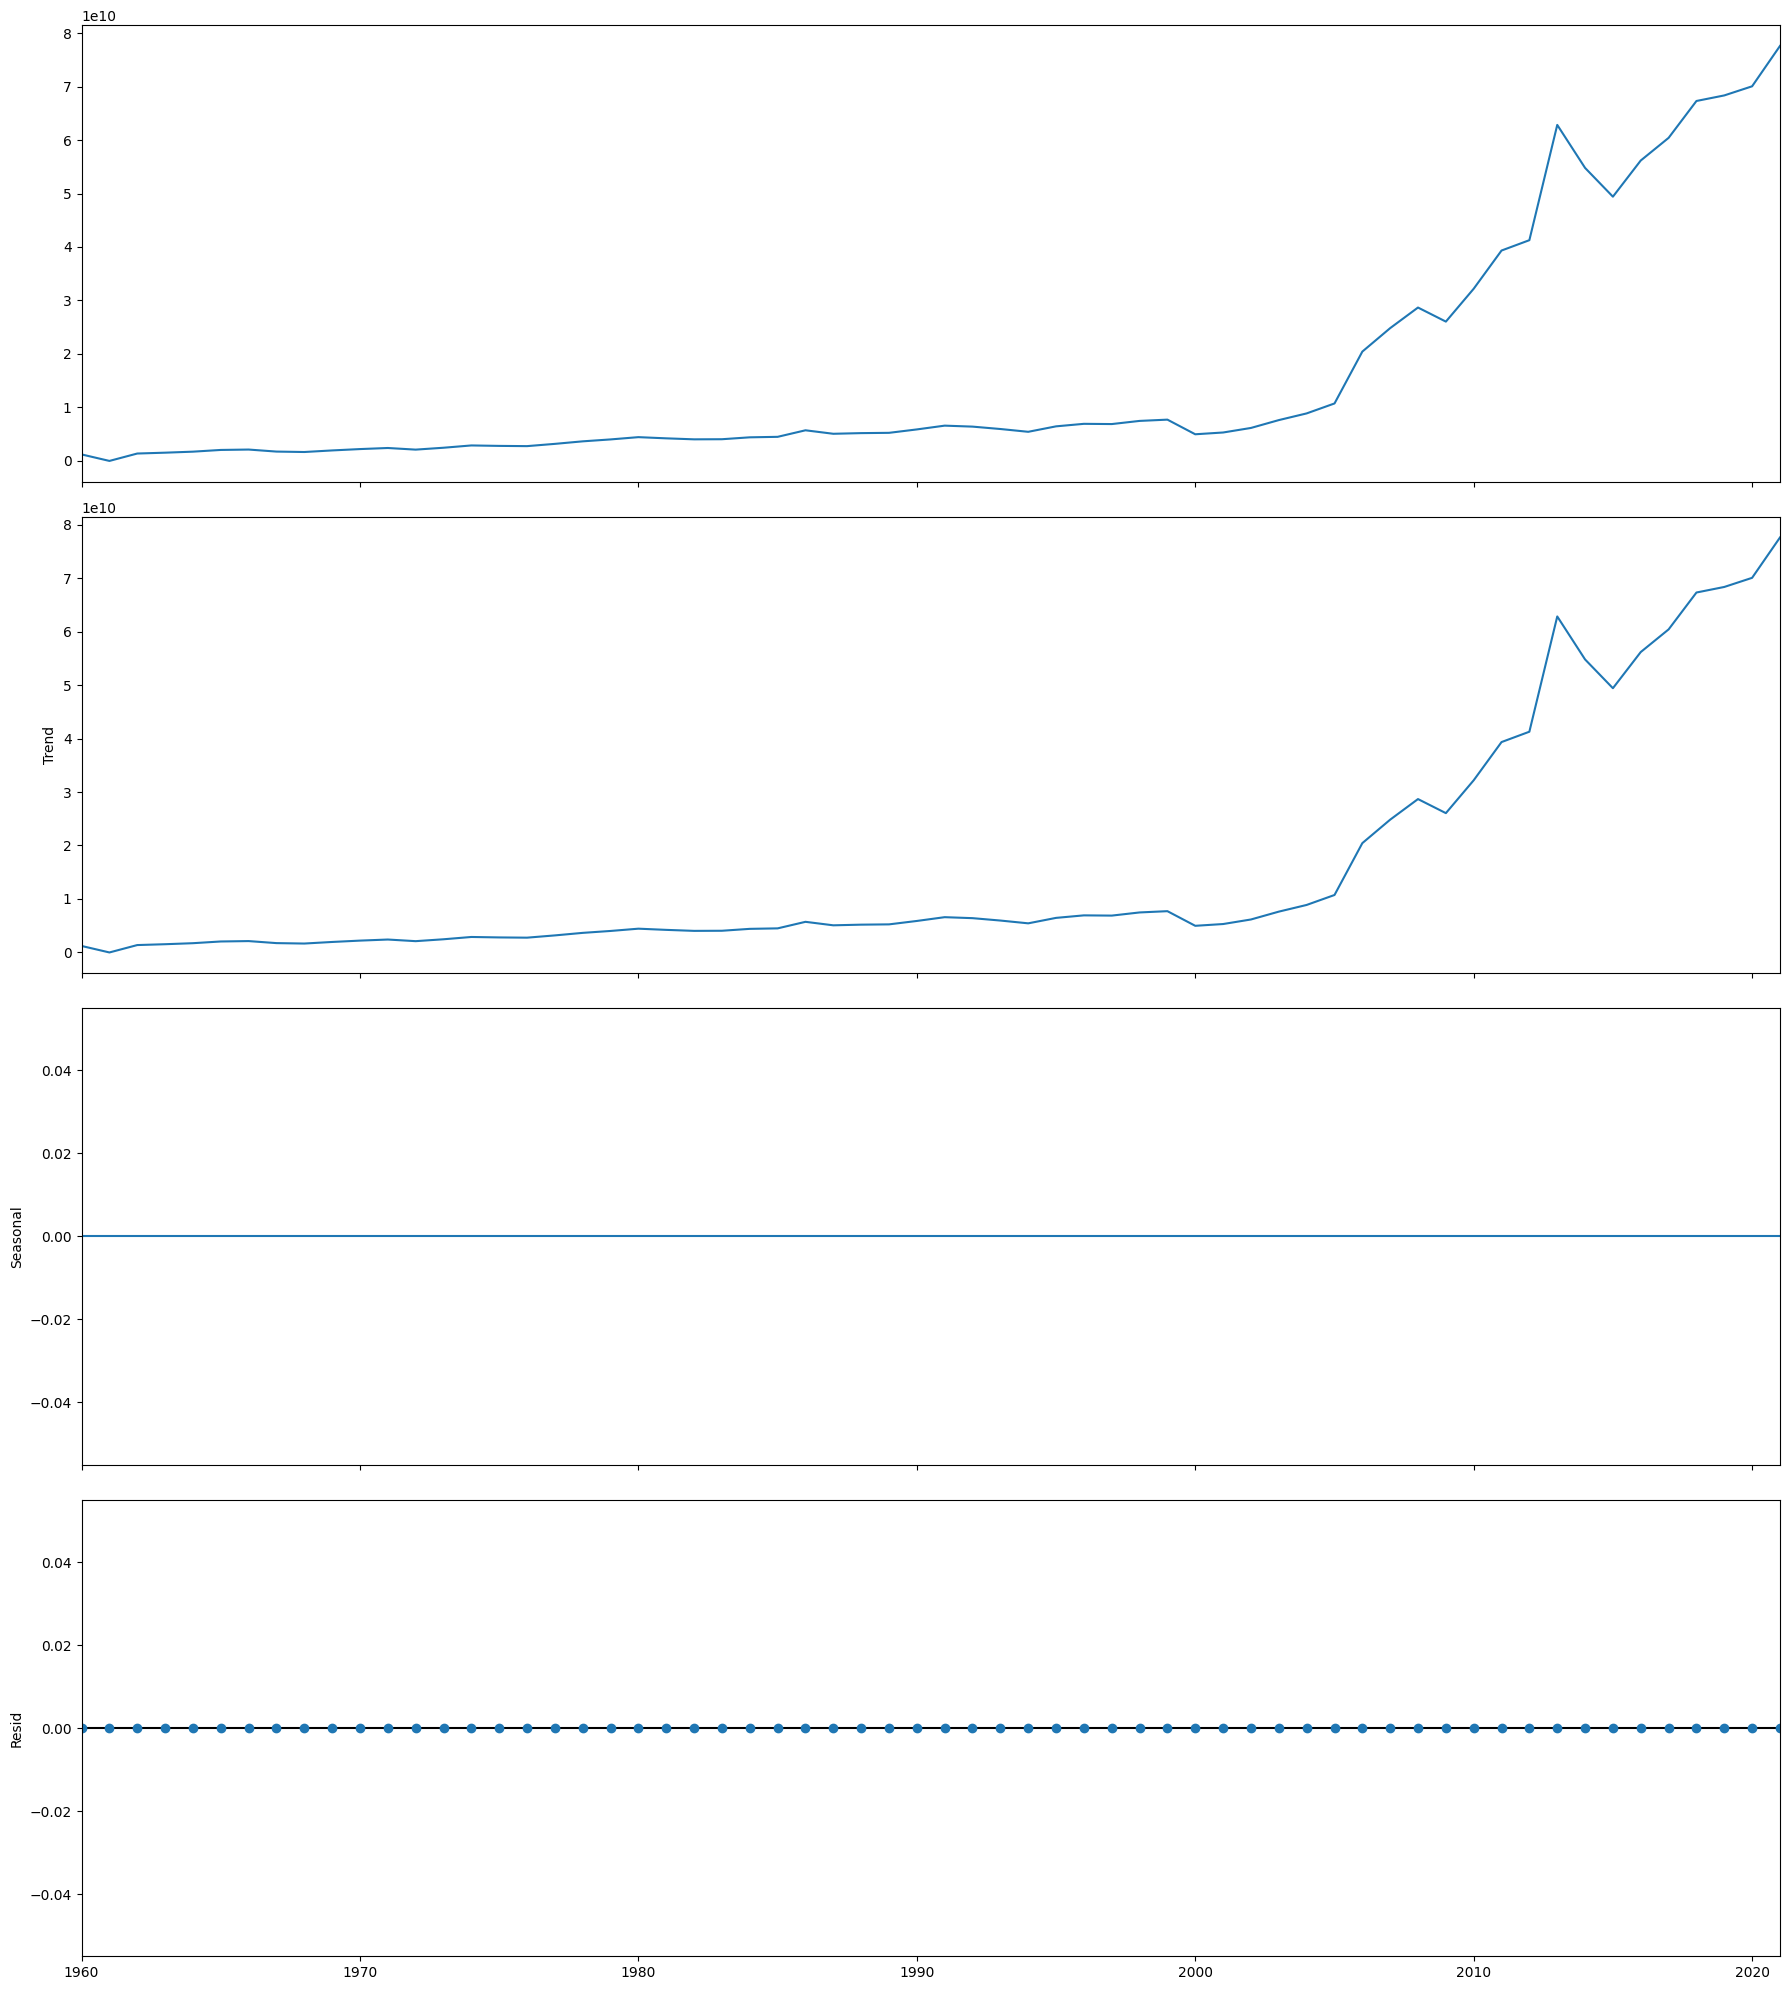

In [ ]:
#Посмотрим на составляющие данных
plt.rcParams["figure.figsize"] = 18, 20

decompose_result = seasonal_decompose(ghana_data)
decompose_result.plot()
plt.show()

Видим явный тренд. Тренд вполне себе здоровый, наблюдаем, как ВВП начало расти в середине 2000-х. Сезонности здесь не наблюдается, не существует, я даже бы сказал.

In [170]:
#Разделим выборку на тренировочную и тестовую

train_df = ghana_data[:-3]
test_df = ghana_data[-3:]

#Проверка
print(ghana_data.shape, train_df.shape, test_df.shape)

(62, 1) (59, 1) (3, 1)


,GDP_col
year,
1961-01-01,6.085434e+08
1962-01-01,6.911765e+08
1963-01-01,1.461485e+09
1964-01-01,1.635854e+09
1965-01-01,1.892157e+09


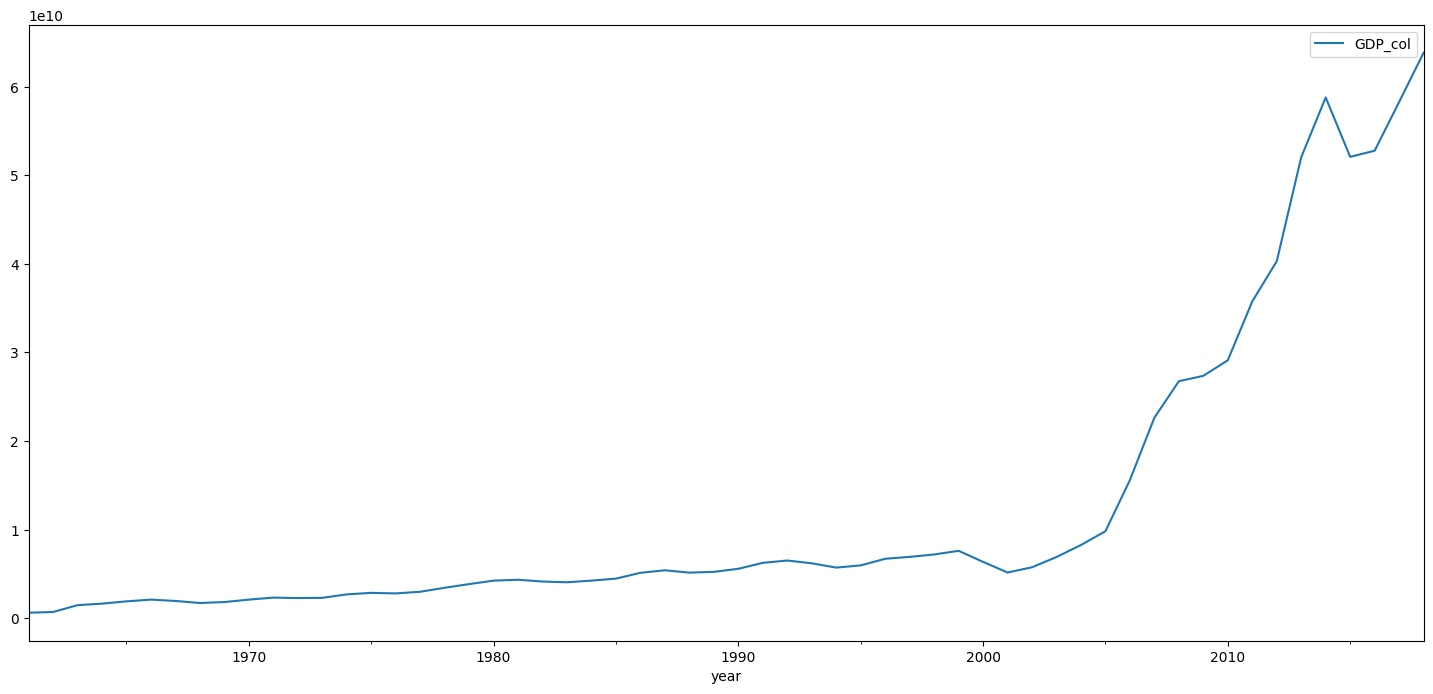

In [171]:
#Строим среднее.

plt.rcParams["figure.figsize"] = 18, 8
rolling_train_data = train_df.rolling(window=2).mean().dropna()
display(rolling_train_data.head())
rolling_train_data.plot()
plt.show()

Первый год (1960) занулялся, потому его пришлось убрать, так как он помешал бы при построении модели. Зато теперь график ровный, без внезапных падений в 0.

In [172]:
#Делаем предсказание по скользящеф средней с помощью ARIMA(0,0,1) и сравниваем с тестовыми данными

rolling_average = ARIMA(rolling_train_data, order=(0,0,1))
model = rolling_average.fit()
forecast = model.forecast(steps=3)
print(forecast)
#Для сверки
print(test_df)

2019-01-01    3.918697e+10
2020-01-01    1.258377e+10
2021-01-01    1.258377e+10
Freq: YS-JAN, Name: predicted_mean, dtype: float64
                 GDP_col
year                    
2019-01-01  6.833754e+10
2020-01-01  7.004320e+10
2021-01-01  7.759428e+10


Предсказание методом скользящего среднего отработало не очень хорошо.

,GDP_col
year,
1964-01-01,1.174230e+09
1965-01-01,1.341457e+09
1966-01-01,1.766667e+09
1967-01-01,1.839557e+09
1968-01-01,1.864816e+09


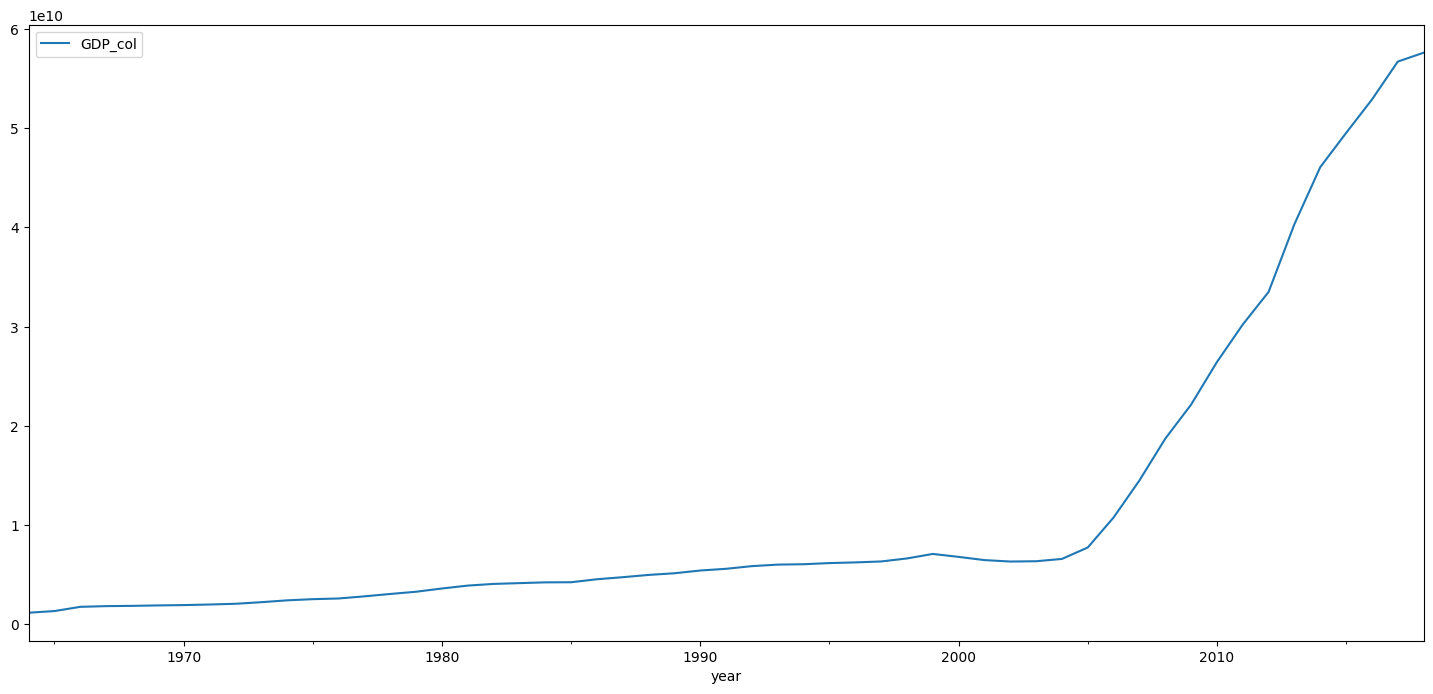

2019-01-01    3.331449e+10
2020-01-01    1.163366e+10
2021-01-01    1.163366e+10
Freq: YS-JAN, Name: predicted_mean, dtype: float64
                 GDP_col
year                    
2019-01-01  6.833754e+10
2020-01-01  7.004320e+10
2021-01-01  7.759428e+10


In [173]:
#Строим среднее.

plt.rcParams["figure.figsize"] = 18, 8
rolling_train_data = train_df.rolling(window=5).mean().dropna()
display(rolling_train_data.head())
rolling_train_data.plot()
plt.show()

rolling_average = ARIMA(rolling_train_data, order=(0,0,1))
model = rolling_average.fit()
forecast = model.forecast(steps=3)
print(forecast)
#Для сверки
print(test_df)

С увеличением окна сглаживания, как и ожидалось, предсказание становится ещё хуже. Потому в данном случае окно 2 - оптимальный вариант.

In [174]:
#Проведём тест на стационарность ряда

# тест на стационарность
result = adfuller(train_df.values)
print("adf: ", result[0])
print("p-value: ", result[1])
print("Critical values: ", result[4])

if result[0] > result[4]['5%']: 
    print ('Ряд нестационарен')
else:
    print ('Ряд стационарен')

adf:  0.6529066974885367
p-value:  0.9888496277665573
Critical values:  {'1%': -3.5745892596209488, '5%': -2.9239543084490744, '10%': -2.6000391840277777}
Ряд нестационарен


In [175]:
#Раз ряд нестационарен, проведём трансформацию и новый тест
print('Степень дифференцирования: 1')
train_df_diff1 = train_df.diff(1).dropna()
# тест на стационарность
result = adfuller(train_df_diff1.values)
print("adf: ", result[0])
print("p-value: ", result[1])
print("Critical values: ", result[4])

if result[0] > result[4]['5%']: 
    print ('Ряд не стационарен')
else:
    print ('Ряд стационарен')

print('-'*50)
print('Степень дифференцирования: 2')
train_df_diff2 = train_df.diff(2).dropna()
# тест на стационарность
result = adfuller(train_df_diff2.values)
print("adf: ", result[0])
print("p-value: ", result[1])
print("Critical values: ", result[4])

if result[0] > result[4]['5%']: 
    print ('Ряд не стационарен')
else:
    print ('Ряд стационарен')

Степень дифференцирования: 1
adf:  -1.670248303832079
p-value:  0.4465029329713883
Critical values:  {'1%': -3.568485864, '5%': -2.92135992, '10%': -2.5986616}
Ряд не стационарен
--------------------------------------------------
Степень дифференцирования: 2
adf:  -3.5836708658260292
p-value:  0.006080989753876957
Critical values:  {'1%': -3.584828853223594, '5%': -2.9282991495198907, '10%': -2.6023438271604937}
Ряд стационарен


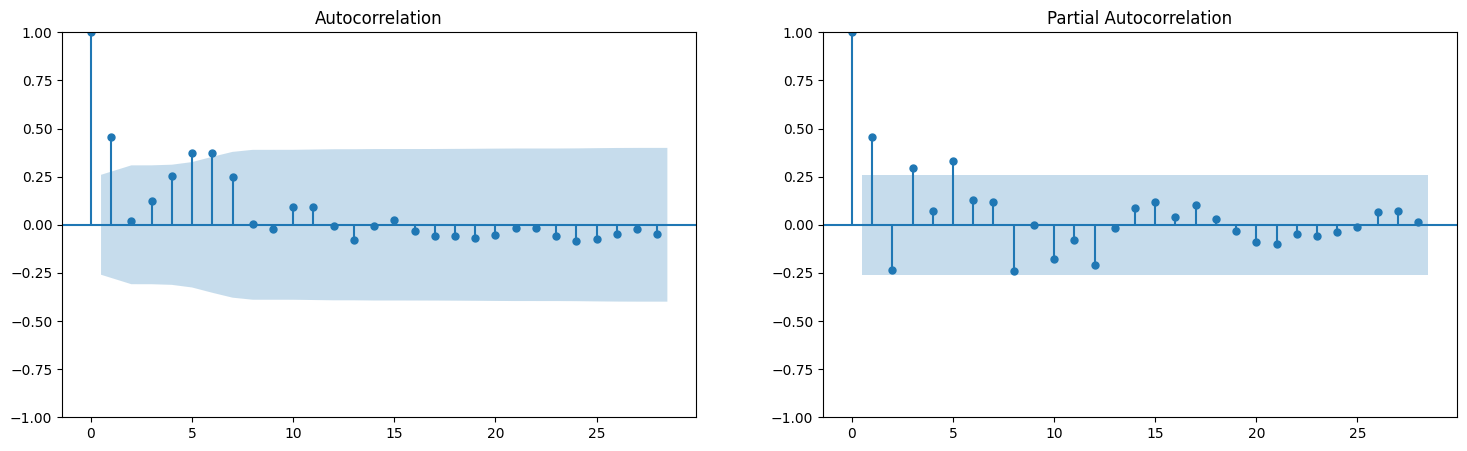

In [176]:
def plot_acf_pacf(series, lags_acf=28, lags_pacf=28):
    plt.rcParams["figure.figsize"] = 18, 5

    fig, axes = plt.subplots(1, 2)

    sgt.plot_acf(series, ax=axes[0], lags=lags_acf)
    sgt.plot_pacf(series, ax=axes[1], lags=lags_pacf, method="ywm")
    plt.show()
    
plot_acf_pacf(train_df_diff2)

Ряд не стационарный, для достижения стационарности нужно продифференцировать его дважды, следовательно, используем ARIMA c d=2. p и q, судя по графикам, следует взять равными 1 каждый.

In [177]:
arima_model = ARIMA(train_df, order=(1, 2, 1))
arima_model_fit = arima_model.fit()
arima_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                GDP_col   No. Observations:                   59
Model:                 ARIMA(1, 2, 1)   Log Likelihood               -1339.208
Date:                Sun, 07 Dec 2025   AIC                           2684.416
Time:                        23:16:08   BIC                           2690.545
Sample:                    01-01-1960   HQIC                          2686.798
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1775      0.082     -2.159      0.031      -0.339      -0.016
ma.L1         -0.8688      0.046    -19.069      0.000      -0.958      -0.780
sigma2       1.96e+19   2.13e-22    9.2e+40      0.000    1.96e+19    1.96e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.17   Jarque-Bera (JB):               276.42
Prob(Q):                              0.68   Prob(JB):                         0.00
Heteroskedasticity (H):             325.65   Skew:                             1.34
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.45
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.95e+56. Standard errors may be unstable.
"""

In [178]:
# А что скажет подбор с помощью pmdarima?

amodel = pm.auto_arima(
    train_df,
    start_p=1,
    d=2,
    start_q=1,
    max_p=6,
    max_q=7,
    # D=1,
    start_P=0,
    seasonal=False,
    test="adf",
    error_action="ignore",
    trace=True,
)

amodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=2687.339, Time=0.17 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=2721.886, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=2706.594, Time=0.01 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=2687.662, Time=0.07 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=2719.959, Time=0.01 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=2686.054, Time=0.03 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=2694.896, Time=0.02 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=2687.799, Time=0.04 sec
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=2695.926, Time=0.02 sec
 ARIMA(3,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=2683.782, Time=0.03 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=2684.416, Time=0.02 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=2693.0

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   59
Model:               SARIMAX(1, 2, 3)   Log Likelihood               -1335.382
Date:                Sun, 07 Dec 2025   AIC                           2680.765
Time:                        23:16:10   BIC                           2690.980
Sample:                    01-01-1960   HQIC                          2684.735
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5682      0.163     -3.487      0.000      -0.888      -0.249
ma.L1         -0.4241      0.235     -1.803      0.071      -0.885       0.037
ma.L2         -0.8256      0.169     -4.886      0.000      -1.157      -0.494
ma.L3          0.5193      0.137      3.790      0.000       0.251       0.788
sigma2      1.868e+19   8.55e-21   2.18e+39      0.000    1.87e+19    1.87e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               173.00
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):             141.34   Skew:                             1.18
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.33e+55. Standard errors may be unstable.
"""

Получили модель, имеющие коэффициент AIC=2684. При этом модель, полученная перебором параметров, чуть лучше по качеству судя по метрикам. Посмотрим, какие значения она предскажет.

In [179]:
#Обучаем модель с самыми лучшими параметрами (нативно, для лучшей совместимости)
arima_model = ARIMA(train_df, order=(1, 2, 3))
arima_model_fit = arima_model.fit()
arima_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                GDP_col   No. Observations:                   59
Model:                 ARIMA(1, 2, 3)   Log Likelihood               -1335.382
Date:                Sun, 07 Dec 2025   AIC                           2680.765
Time:                        23:16:10   BIC                           2690.980
Sample:                    01-01-1960   HQIC                          2684.735
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5682      0.163     -3.487      0.000      -0.888      -0.249
ma.L1         -0.4241      0.235     -1.803      0.071      -0.885       0.037
ma.L2         -0.8256      0.169     -4.886      0.000      -1.157      -0.494
ma.L3          0.5193      0.137      3.790      0.000       0.251       0.788
sigma2      1.868e+19   8.55e-21   2.18e+39      0.000    1.87e+19    1.87e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               173.00
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):             141.34   Skew:                             1.18
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.33e+55. Standard errors may be unstable.
"""

In [180]:
prediction = arima_model_fit.predict(-3)
print(prediction)
print(test_df)

2016-01-01    6.204277e+10
2017-01-01    5.858119e+10
2018-01-01    6.672175e+10
Freq: YS-JAN, Name: predicted_mean, dtype: float64
                 GDP_col
year                    
2019-01-01  6.833754e+10
2020-01-01  7.004320e+10
2021-01-01  7.759428e+10


А вот тут результаты уже очень похожи! Посмотрим на них в графиках.

In [ ]:
#Подготовим данные для графиков
pred_df = pd.DataFrame(index=ghana_data.index)

pred_df["model_preds"] = arima_model_fit.predict(
    start=test_df.index[0], end=test_df.index[-1]
)


pred_df['GDP_col'] = ghana_data['GDP_col']

forecast = arima_model_fit.get_forecast(len(test_df.index))
forecast_df = forecast.conf_int(alpha=0.05)  # Confidence level of 95%
display(forecast_df)
pred_df.at[test_df.index, "model_preds_lower"] = forecast_df["lower GDP_col"]
pred_df.at[test_df.index, "model_preds_upper"] = forecast_df["upper GDP_col"]

,lower GDP_col,upper GDP_col
2019-01-01,5.941329e+10,7.636831e+10
2020-01-01,6.050774e+10,8.455877e+10
2021-01-01,6.155656e+10,8.879040e+10


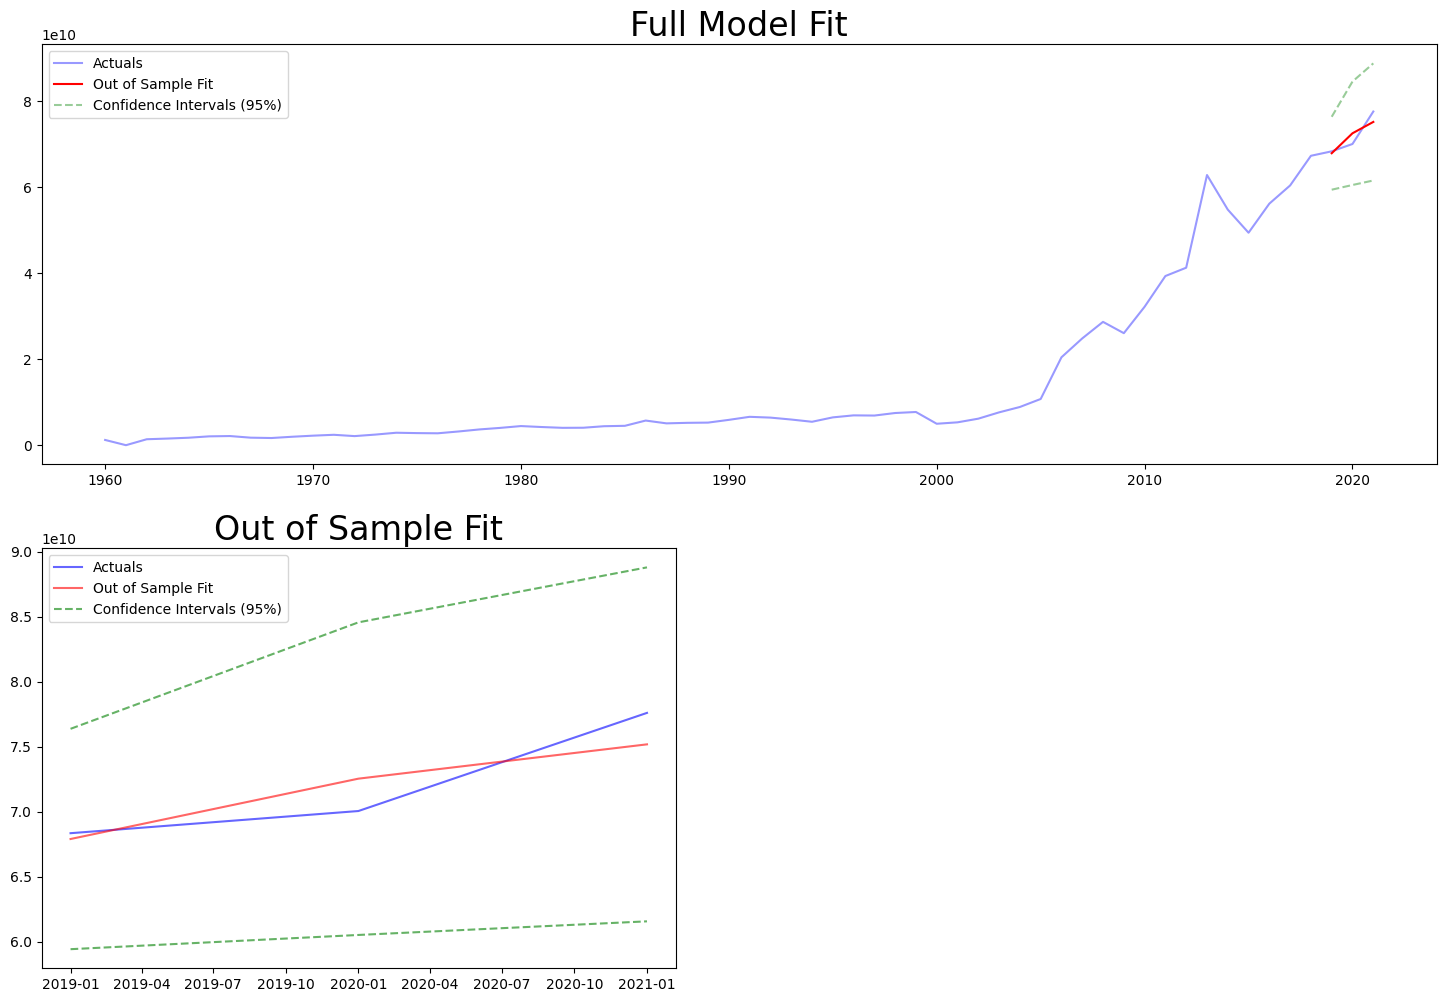

In [ ]:
#Построим график для наглядности результатов обучения
plt.rcParams["figure.figsize"] = 18, 12

plt.subplot(2, 1, 1)
plt.plot(pred_df['GDP_col'], color="blue", label="Actuals", alpha=0.4)

plt.plot(
    pred_df.loc[test_df.index]["model_preds"],
    color="red",
    linestyle="-",
    label="Out of Sample Fit",
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_lower"],
    color="green",
    linestyle="--",
    label="Confidence Intervals (95%)",
    alpha=0.4,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_upper"],
    color="green",
    linestyle="--",
    alpha=0.4,
)

plt.title("Full Model Fit", size=24)
plt.legend()

plt.subplot(2, 2, 3)

plt.plot(
    pred_df.loc[test_df.index]['GDP_col'], color="blue", label="Actuals", alpha=0.6
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds"],
    color="red",
    linestyle="-",
    label="Out of Sample Fit",
    alpha=0.6,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_lower"],
    color="green",
    linestyle="--",
    label="Confidence Intervals (95%)",
    alpha=0.6,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_upper"],
    color="green",
    linestyle="--",
    alpha=0.6,
)

plt.title("Out of Sample Fit", size=24)
plt.legend()

plt.show()

В целом, модель уловила смысл. Но, пожалуй, хотелось бы выборку побольше, так как точность не идеальная, и есть подозрение, что дальше модель будет расходиться с реальностью. При этом модель на скользящих средних не показала даже близко такой результат. Очевидно, что из них Арима лучше. 

## Интерполяция и сэмплирование

Очень надеюсь, что в заданиях имеются в виду изначальные данные. Именно от них и буду отталкиваться.

In [ ]:
ghana_data.asfreq(freq='AS').isnull().sum()

GDP_col    0
dtype: int64

Судя по ответу, пропусков нет. Хотя на самом деле он есть, его я увидел еще в начале, в виде околонулевого значения. Попрубуем иначе. Будем считать, что ВВП не может быть 1000 долларов, и это выброс.

In [184]:
ghana_data[ghana_data['GDP_col']<1000]

,GDP_col
year,
1961-01-01,0.0


Вот он, как и ожидалось. На всякий случай проверим, есть ли вообще пропущенные данные, тем более, что нужно по заданию.

In [185]:
ghana_data.isna().sum()

GDP_col    0
dtype: int64

Нет, больше пропусков нет. Далее по заданию сказано заменить нулевое значение на NaN. Ну, так и сделаем.

In [186]:
ghana_data['GDP_col'] = ghana_data['GDP_col'].apply(lambda x: np.nan if x==0 else x)
ghana_data.isna().sum()

GDP_col    1
dtype: int64

Теперь пропуск можно легко заметить. Заменим его значением, полученным интерполяцией.

In [187]:
ghana_data = pd.DataFrame(ghana_data['GDP_col'].interpolate(method='linear'))
print('Значение после проведения интерполяции:', ghana_data.loc['1961-01-01'])

Значение после проведения интерполяции: GDP_col    1.299720e+09
Name: 1961-01-01 00:00:00, dtype: float64


Далее разделим данные на выборки и проверим их на стационарность. Очевидно, что из-за одного значения ряд стационарным не станет. Убедимся в этом:

In [188]:
#Разделим выборку на тренировочную и тестовую

train_df = ghana_data[:-3]
test_df = ghana_data[-3:]

#Проверка
print(ghana_data.shape, train_df.shape, test_df.shape)

#Проведём тест на стационарность ряда

# тест на стационарность
result = adfuller(train_df.values)
print("adf: ", result[0])
print("p-value: ", result[1])
print("Critical values: ", result[4])

if result[0] > result[4]['5%']: 
    print ('Ряд нестационарен')
else:
    print ('Ряд стационарен')

(62, 1) (59, 1) (3, 1)
adf:  0.8030073326980115
p-value:  0.9916845572455877
Critical values:  {'1%': -3.5745892596209488, '5%': -2.9239543084490744, '10%': -2.6000391840277777}
Ряд нестационарен


In [189]:
#Раз ряд нестационарен, проведём трансформацию и новый тест
print('Степень дифференцирования: 1')
train_df_diff1 = train_df.diff(1).dropna()
# тест на стационарность
result = adfuller(train_df_diff1.values)
print("adf: ", result[0])
print("p-value: ", result[1])
print("Critical values: ", result[4])

if result[0] > result[4]['5%']: 
    print ('Ряд не стационарен')
else:
    print ('Ряд стационарен')
    
print('-'*50)
print('Степень дифференцирования: 2')
train_df_diff2 = train_df.diff(2).dropna()
# тест на стационарность
result = adfuller(train_df_diff2.values)
print("adf: ", result[0])
print("p-value: ", result[1])
print("Critical values: ", result[4])

if result[0] > result[4]['5%']: 
    print ('Ряд не стационарен')
else:
    print ('Ряд стационарен')

Степень дифференцирования: 1
adf:  -1.8255652246436056
p-value:  0.3678451527656314
Critical values:  {'1%': -3.568485864, '5%': -2.92135992, '10%': -2.5986616}
Ряд не стационарен
--------------------------------------------------
Степень дифференцирования: 2
adf:  -3.99980344094915
p-value:  0.0014115408436661263
Critical values:  {'1%': -3.584828853223594, '5%': -2.9282991495198907, '10%': -2.6023438271604937}
Ряд стационарен


adf стал меньше, чем до этого.

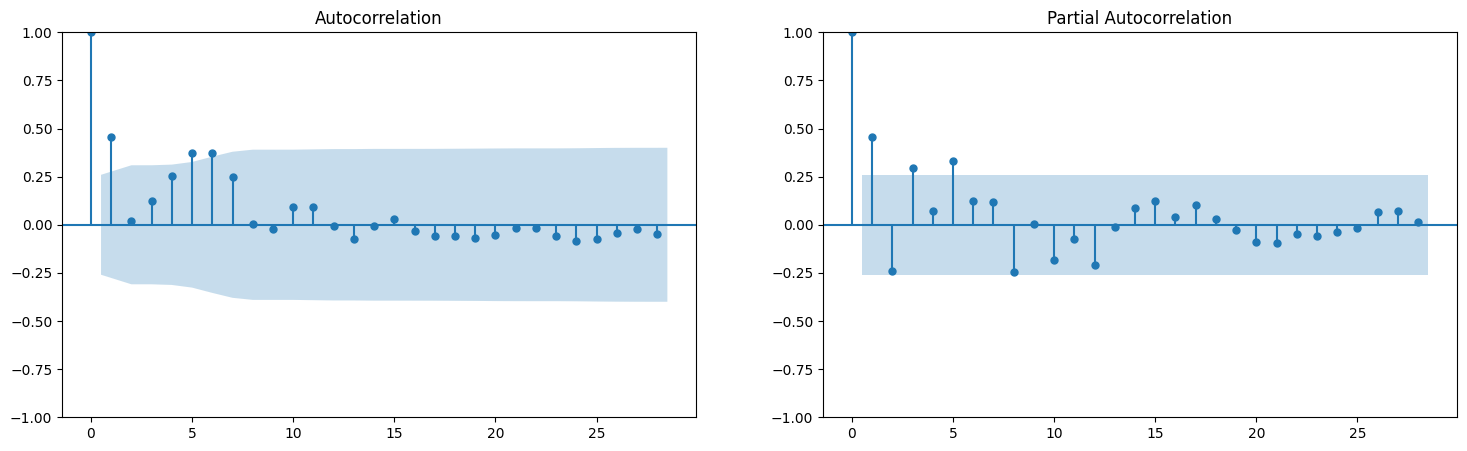

In [190]:
plot_acf_pacf(train_df_diff2)

График не изменился внешне. Хоть и напрашиваются те же параметры, что и ранее, воспользуюсь автоаримой.

In [191]:
amodel = pm.auto_arima(
    train_df,
    start_p=1,
    d=2,
    start_q=1,
    max_p=6,
    max_q=7,
    # D=1,
    start_P=0,
    seasonal=False,
    test="adf",
    error_action="ignore",
    trace=True,
)

amodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=2687.479, Time=0.04 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=2721.621, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=2706.528, Time=0.01 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=2687.799, Time=0.02 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=2719.683, Time=0.01 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=2686.221, Time=0.02 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=2694.822, Time=0.01 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=2687.929, Time=0.04 sec
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=2695.861, Time=0.02 sec
 ARIMA(3,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=2683.709, Time=0.02 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=2684.377, Time=0.02 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=2692.9

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   59
Model:               SARIMAX(1, 2, 3)   Log Likelihood               -1335.257
Date:                Sun, 07 Dec 2025   AIC                           2680.513
Time:                        23:16:12   BIC                           2690.729
Sample:                    01-01-1960   HQIC                          2684.483
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5586      0.171     -3.271      0.001      -0.893      -0.224
ma.L1         -0.4271      0.248     -1.724      0.085      -0.913       0.059
ma.L2         -0.8246      0.185     -4.467      0.000      -1.186      -0.463
ma.L3          0.5228      0.135      3.866      0.000       0.258       0.788
sigma2      1.864e+19   1.02e-20   1.84e+39      0.000    1.86e+19    1.86e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               179.81
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):             434.94   Skew:                             1.19
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.4e+55. Standard errors may be unstable.
"""

Что мы имеем на данном этапе? Автоарима подобрала те же параметры, но значение AIC незначительно улучшилось, что значит, что интерполяция в данном случае (есть подозрение, что почти всегда) работает лучше, хоть и не намного.

In [ ]:
#Задание 8.3
#Валидация временных рядов

tscv = TimeSeriesSplit(n_splits=3, test_size=7)

train_test_groups = tscv.split(ghana_data.GDP_col)
for train_index, test_index in train_test_groups:
    print("TRAIN size:", len(train_index), "TEST size:", len(test_index))
    
print('-'*40)

#Как будто бы эта строчка не работает
tscv = TimeSeriesSplit(max_train_size=ghana_data.GDP_col.count()-7)

train_test_groups = tscv.split(ghana_data.GDP_col)
for train_index, test_index in train_test_groups:
    print("TRAIN size:", len(train_index), "TEST size:", len(test_index))

TRAIN size: 41 TEST size: 7
TRAIN size: 48 TEST size: 7
TRAIN size: 55 TEST size: 7
----------------------------------------
TRAIN size: 12 TEST size: 10
TRAIN size: 22 TEST size: 10
TRAIN size: 32 TEST size: 10
TRAIN size: 42 TEST size: 10
TRAIN size: 52 TEST size: 10


Хотя в задании намекается, что вывод должен быть один, он разный.

Попробуем посчитать волатильность временного ряда.

In [193]:
ghana_data.head()

,GDP_col
year,
1960-01-01,1.217087e+09
1961-01-01,1.299720e+09
1962-01-01,1.382353e+09
1963-01-01,1.540616e+09
1964-01-01,1.731092e+09


In [194]:
# # Более простой подход
# ghana_data['gdp_vol'] = ghana_data['GDP_col'].pct_change(1) * 100
# ghana_data['gdp_vol'] = ghana_data['gdp_vol'].abs()

# display(ghana_data.head())

,GDP_col,gdp_vol
year,,
1960-01-01,1.217087e+09,NaN
1961-01-01,1.299720e+09,6.789413
1962-01-01,1.382353e+09,6.357759
1963-01-01,1.540616e+09,11.448835
1964-01-01,1.731092e+09,12.363636


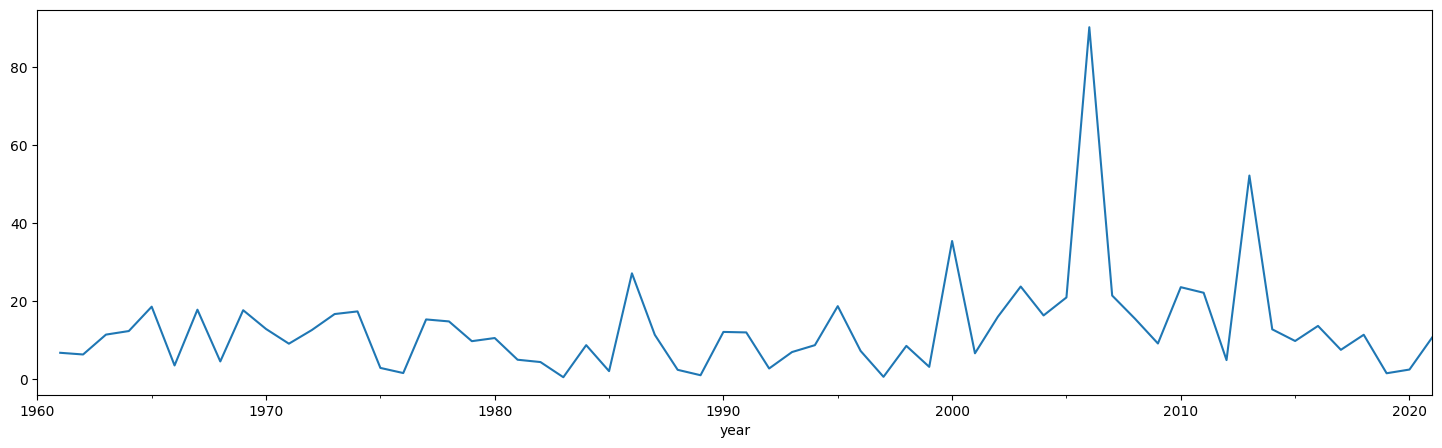

In [195]:
#Добавим новый столбец с данными о волатильности и построим график этого
ghana_data['gdp_vol'] = ghana_data.GDP_col.pct_change(1).mul(100).abs()
display(ghana_data.head())

ghana_data["gdp_vol"].plot()
plt.show()

                 GDP_col    gdp_vol
year                               
1960-01-01  1.217087e+09        NaN
1961-01-01  1.299720e+09   6.789413
1962-01-01  1.382353e+09   6.357759
1963-01-01  1.540616e+09  11.448835
1964-01-01  1.731092e+09  12.363636
1965-01-01  2.053221e+09  18.608414
1966-01-01  2.126050e+09   3.547067
1967-01-01  1.746806e+09  17.837977
1968-01-01  1.666910e+09   4.573826
1969-01-01  1.962051e+09  17.705882
1970-01-01  2.215029e+09  12.893553
1971-01-01  2.417108e+09   9.123051
1972-01-01  2.112293e+09  12.610723
1973-01-01  2.465493e+09  16.721166
1974-01-01  2.894410e+09  17.396804
1975-01-01  2.810106e+09   2.912634
1976-01-01  2.765254e+09   1.596101
1977-01-01  3.189429e+09  15.339433
1978-01-01  3.662478e+09  14.831798
1979-01-01  4.020228e+09   9.767969
1980-01-01  4.445228e+09  10.571547
1981-01-01  4.222442e+09   5.011815
1982-01-01  4.035994e+09   4.415626
1983-01-01  4.057275e+09   0.527271
1984-01-01  4.412280e+09   8.749833
1985-01-01  4.504342e+09   2

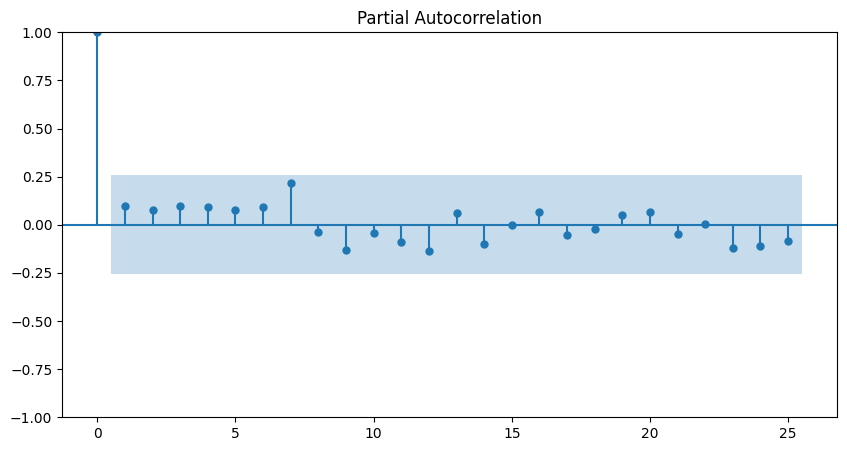

In [196]:
#Разделим выборку на тренировочную и тестовую

train_df = ghana_data.loc[:'2018-01-01']
test_df = ghana_data.loc['2019-01-01':]

print(train_df)
#Проверка
print(ghana_data.shape, train_df.shape, test_df.shape)

plt.rcParams["figure.figsize"] = 10, 5

sgt.plot_pacf(train_df.gdp_vol[1:], lags=25, method="ywm")
plt.show()

Ну и уже по классике, проведём тест на стационарность и сразу приведем ряд к стационарному

In [197]:
#Проведём тест на стационарность ряда

# тест на стационарность
result = adfuller(train_df.gdp_vol[1:].values)
print("adf: ", result[0])
print("p-value: ", result[1])
print("Critical values: ", result[4])

if result[0] > result[4]['5%']: 
    print ('Ряд нестационарен')
else:
    print ('Ряд стационарен')

adf:  -6.725311059553779
p-value:  3.4014596148856493e-09
Critical values:  {'1%': -3.5506699942762414, '5%': -2.913766394626147, '10%': -2.5946240473991997}
Ряд стационарен


Чудеса, ряд сразу же стационарный.

Перейдём к построению Garch-модели. Для этого предварительно необходимо выполнить преобразование данных.

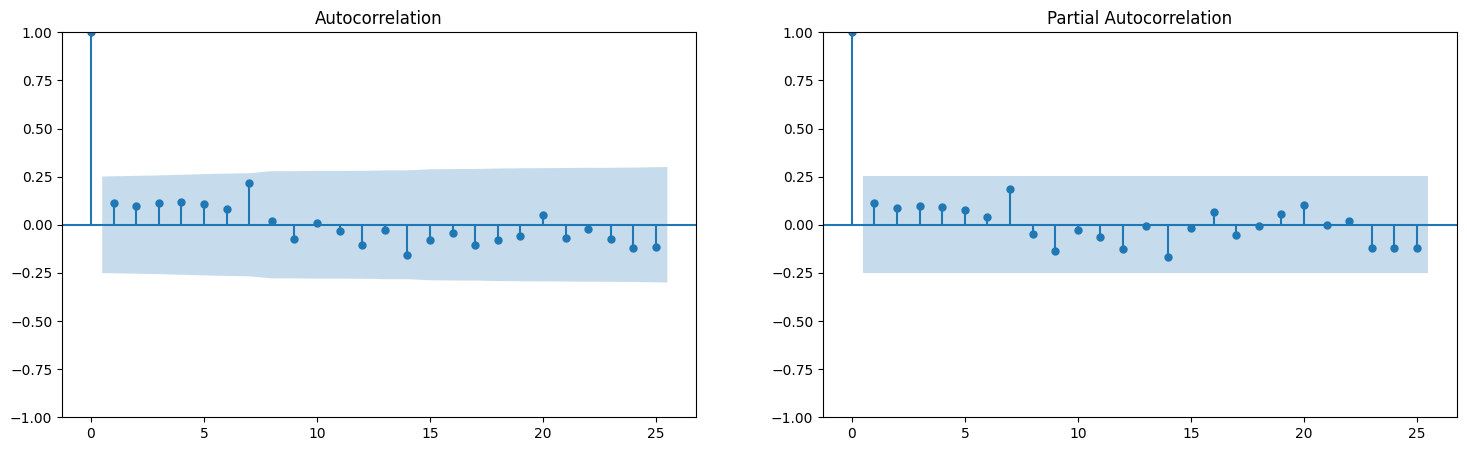

In [198]:
garch_df = pd.DataFrame(ghana_data["gdp_vol"].loc[ghana_data.index])

garch_df.loc[train_df.index, "gdp_vol"] = train_df["gdp_vol"].dropna()

#В уроке это не делается, но для своего спокойствия построю график автокорреляции к частичной корреляции
plot_acf_pacf(garch_df['gdp_vol'][1:], lags_acf=25, lags_pacf=25)

In [199]:
#Построение Garch-модели с параметрами из урока. Почему они такие, там не поясняется, 
# поэтому просто попробую с такими же.
model_train = arch_model(garch_df["gdp_vol"].dropna(), p=2, q=2)

# в параметре last_obs указываем последний объект, до которого будем совершать обучение.
# в нашем случае это до первого объекта из test выборки

model_results = model_train.fit(last_obs=test_df.index[0], update_freq=5)

Iteration:      5,   Func. Count:     39,   Neg. LLF: 228.6095884373151
Iteration:     10,   Func. Count:     74,   Neg. LLF: 226.7262980616956
Iteration:     15,   Func. Count:    109,   Neg. LLF: 226.6994206641058
Optimization terminated successfully    (Exit mode 0)
            Current function value: 226.5978300547896
            Iterations: 19
            Function evaluations: 139
            Gradient evaluations: 19


In [200]:
#Результаты
model_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                gdp_vol   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -226.598
Distribution:                  Normal   AIC:                           465.196
Method:            Maximum Likelihood   BIC:                           477.558
                                        No. Observations:                   58
Date:                Sun, Dec 07 2025   Df Residuals:                       57
Time:                        23:16:13   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            12.3129      2.221      5.545  2.946e-08 [  7.960, 16.665]
                            Volatility Model                            
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          3.6689     17.107      0.214      0.830 [-29.860, 37.198]
alpha[1]   1.0875e-10      0.107  1.016e-09      1.000 [ -0.210,  0.210]
alpha[2]   3.6529e-07      0.162  2.254e-06      1.000 [ -0.318,  0.318]
beta[1]        1.0000      1.008      0.992      0.321 [ -0.976,  2.976]
beta[2]    3.1769e-07      0.979  3.246e-07      1.000 [ -1.918,  1.918]
========================================================================

Covariance estimator: robust
"""

In [201]:
#Построим ещё одну модель, с параметрами, по смыслу подходящими для данного случая.
model_main = arch_model(garch_df["gdp_vol"].dropna(), p=7, q=7)

# в параметре last_obs указываем последний объект, до которого будем совершать обучение.
# в нашем случае это до первого объекта из test выборки

model_results = model_main.fit(last_obs=test_df.index[0], update_freq=5)

Iteration:      5,   Func. Count:     91,   Neg. LLF: 234.38048115955718
Iteration:     10,   Func. Count:    179,   Neg. LLF: 214.61759052175603
Iteration:     15,   Func. Count:    265,   Neg. LLF: 214.40871495512866
Iteration:     20,   Func. Count:    350,   Neg. LLF: 214.10079395318482
Iteration:     25,   Func. Count:    435,   Neg. LLF: 214.01143994526097
Optimization terminated successfully    (Exit mode 0)
            Current function value: 214.00780231871062
            Iterations: 29
            Function evaluations: 492
            Gradient evaluations: 28


In [202]:
#Результаты
model_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                gdp_vol   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -214.008
Distribution:                  Normal   AIC:                           460.016
Method:            Maximum Likelihood   BIC:                           492.983
                                        No. Observations:                   58
Date:                Sun, Dec 07 2025   Df Residuals:                       57
Time:                        23:16:13   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            11.8666      1.572      7.550  4.349e-14 [  8.786, 14.947]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega         44.1055     42.301      1.043      0.297    [-38.802,1.270e+02]
alpha[1]   3.2351e-08  7.767e-02  4.165e-07      1.000      [ -0.152,  0.152]
alpha[2]   7.8463e-08  2.299e-02  3.412e-06      1.000 [-4.507e-02,4.507e-02]
alpha[3]   6.5621e-14  6.853e-02  9.576e-13      1.000      [ -0.134,  0.134]
alpha[4]   3.6162e-03  1.492e-02      0.242      0.809 [-2.563e-02,3.286e-02]
alpha[5]   6.2496e-14  1.274e-02  4.906e-12      1.000 [-2.497e-02,2.497e-02]
alpha[6]       0.7319      0.915      0.800      0.424      [ -1.062,  2.525]
alpha[7]       0.1024      0.643      0.159      0.873      [ -1.157,  1.362]
beta[1]    5.7084e-07      0.501  1.139e-06      1.000      [ -0.982,  0.982]
beta[2]    3.6496e-07  6.190e-02  5.896e-06      1.000      [ -0.121,  0.121]
beta[3]    3.4349e-07  2.869e-02  1.197e-05      1.000 [-5.624e-02,5.624e-02]
beta[4]    3.0295e-07  9.122e-02  3.321e-06      1.000      [ -0.179,  0.179]
beta[5]    1.7888e-05  5.268e-02  3.396e-04      1.000      [ -0.103,  0.103]
beta[6]    3.6179e-07  3.014e-02  1.200e-05      1.000 [-5.908e-02,5.908e-02]
beta[7]    2.9083e-07      1.155  2.517e-07      1.000      [ -2.265,  2.265]
=============================================================================

Covariance estimator: robust
"""

Построил 2 модели: 1 с параметрами из урока, и 2 с теми параметрами, которые должны быть, исходя из графика. И странно то, что хоть вторая и должна лучше подходить для этого кейса, первая показала лучшую метрику по предсказанию.

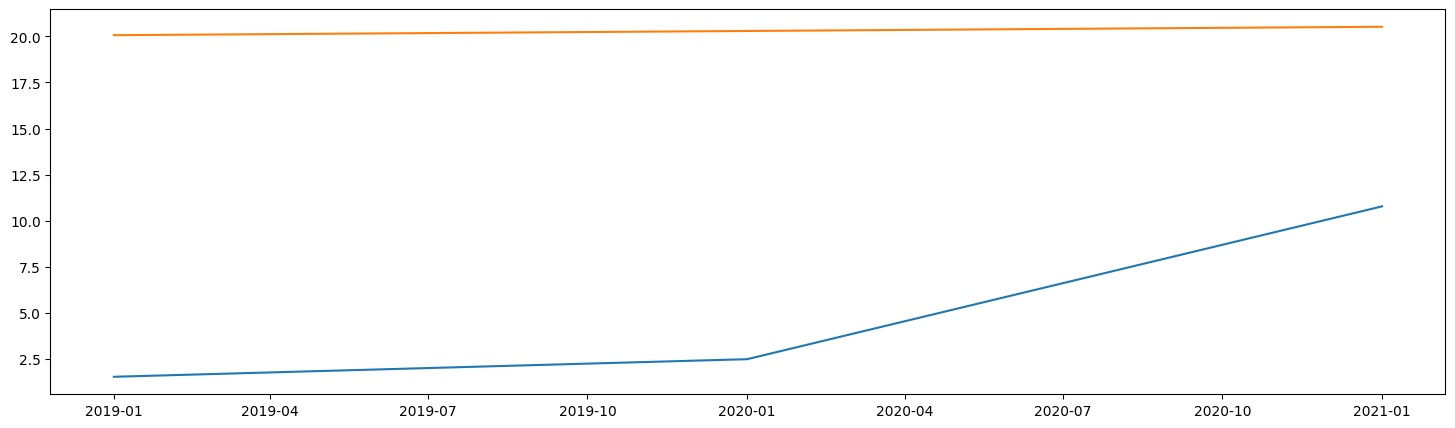

In [203]:
#Разделим выборки на тренировочную и тестовую и обучим на них 
# базовую модель линейной регрессии
X_train = pd.DataFrame(range(ghana_data["gdp_vol"].shape[0]))[
    : train_df.shape[0]
].fillna(0)
X_test = pd.DataFrame(range(ghana_data["gdp_vol"].shape[0]))[
    train_df.shape[0] :
]
y_train = train_df["gdp_vol"].fillna(0)
y_test = test_df["gdp_vol"]


lr = LinearRegression()
lr.fit(X_train, y_train)
lr_predict = lr.predict(X_test)


plt.plot(y_test)
plt.plot(pd.Series(lr_predict, index=y_test.index))
plt.show()

In [204]:
#Получим от модели предсказания
predictions_df = test_df.copy()
predictions_df["Predictions"] = model_results.forecast().residual_variance.loc[
    test_df.index
]

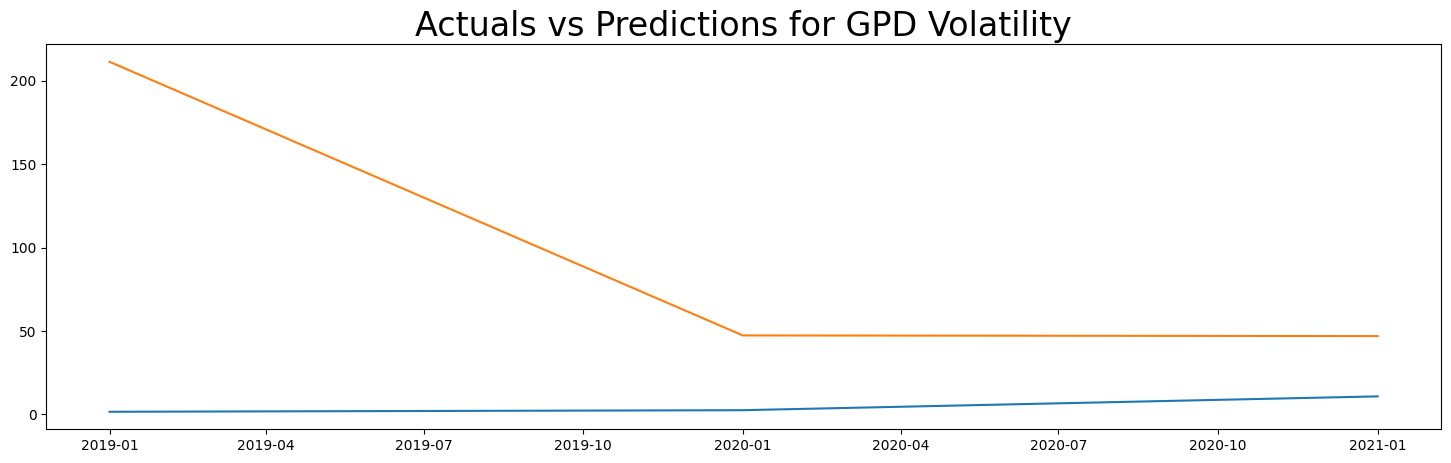

In [205]:
#Визуализируем тестоваю выборку и получившиеся предсказания
plt.rcParams["figure.figsize"] = 18, 5

plt.plot(predictions_df["gdp_vol"].abs())
plt.plot(predictions_df["Predictions"])

plt.title("Actuals vs Predictions for GPD Volatility", size=24)

plt.show()

In [206]:
print('Среднеквадратичная ошибка:', mean_squared_error(
    predictions_df["gdp_vol"].abs(), predictions_df["Predictions"]
))

Среднеквадратичная ошибка: 15799.81566534356


Ну, результат в целом удручающий. Он даже хуже, чем модель линейной регрессии. Подозреваю, что это из-за недостатка данных. Модели просто не хватило данных для нормального обучения, о чем говорит большая среднеквадратичная ошибка. К тому же стоит отметить почти постоянно растущий тренд. Одного небольшого падения для качественного модели, подозреваю, может не хватить. Если принять это во внимание, можно увидеть, что GARCH модель пытается формировать какие-то "предсказательные" рельефности на графике, в отличие от модели линейной регрессии, что в перспективе может быть интересно. Если смысл для валидации подобного недообученного временного ряда? Не думаю. Для начала стоит разбить данные на более мелкие промежутки, хотя бы помесячно или посезонно, иначе данные и модель не будут репрезентативными. Но такой задачи не стоит, потому на этом пока заканчиваем.